## II. Machine Learning Approach

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from IPython.display import display
from sklearn.base import clone
import warnings
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from joblib import dump
from collections import defaultdict

In [4]:
Data = pd.read_csv('C:/Users/obouk/OneDrive/Bureau/Project Data/Needed/Code/Final_Data.csv')

In [5]:
Data.shape

(1620, 14)

### 1. Introduction

#### In this section, we will train four machine learning models using the preprocessed dataset 'Data'. The dataset contains 1620 samples, 11 features and 3 target variables that(RSRP, RSRQ and SINR) that we aim to predict. The data focuses exclusively on Suburban and Urban environments only in multi-frequency band configurations.

#### Based on the research and the specific requirement of our LTE coverage prediction task, we will use the following models:
#### 1. Random Forest: Demonstrates strong performance in Urban/ Suburban Areas and handles data multi-frequency band effectively, its ensemble is well suited for numerical target prediction and mitigates noise common in dynamic environments.
#### 2. Support Vector Regression(SVR): Excels in urban environments, adapted to moderate-sized datasets , and accommodates both numerical and categorical features after preprocessing.
#### 3. Gradient Boosting Tree(GBT): Models complex, non-linear relatrioships in multi-frequency environments through sequential tree ensembles, making it ideat for predicting countinous numerical targets.
#### Extremely Randomised Trees(ERTR): Recduce overfitting in Dynamic Urban/Suburban environments by introducing additional randomness during splits, ensuring robustness in multi-frequency band scenarios.

#### The moderate size(1620 rows) aligns well with these models, avoiding computational bottlenecks while maintaining predictive accuracy. This selection balances performance, computational efficient, and environmental suitability for LTE coverage prediction.


### 2.1. Machine Learning Regression Models Benchmarking (Pre-Tuning Phase)

#### What follows is an evaluation performance of four regression models, Random Forest 'RF', Gradient Boosted Trees 'GBT', Extremely Randomised Trees 'ERTR', and Support Vector REgressor 'SVR' on the dataset 'Data' to predict three target variables: RSRP, SINR, and RSRQ. By applying 10-fold cross-validation for model training to assess robustness and detect overfitting, while 20% of data is held out as an unseen test set. In this initial phase, the models are evaluated without hyperparameter tuning, with the exception of 'SVR', which requires a proper feature scaling due to its sensitivity to input feature scales, the algorithm might focus too much on larger numerical value of attributes.

#### The evaluation process is repeated for each target variable, recording Root Mean Square Error 'RMSE' and R2 scores for training, validation and test sets. Additionally, the computational time for each model's training and evaluation is measured to compare efficiency. These metrics will help identify the most suitable algorithm for each target before proceeding to hyperparameter optimisation.

In [10]:
# Define features and targets
X = Data.drop(columns=['RSRP (dBm)', 'SINR (dB)', 'RSRQ (dB)'])

targets ={
'RSRP (dBm)':  Data['RSRP (dBm)'],
'SINR (dB)':  Data['SINR (dB)'],
'RSRQ (dB)': Data['RSRQ (dB)']
}

In [11]:
#initialise K-fold cross validation
cv = KFold(n_splits = 10, shuffle = True, random_state = 19)

In [12]:
#Define models without hyperparameters, n_estimators is 100 by default
models ={
    'RF' : RandomForestRegressor(random_state= 19),
    'GBT' : GradientBoostingRegressor(random_state= 19),
    'ERTR' : ExtraTreesRegressor(random_state= 19),
    'SVR' : Pipeline([
        ('scaler', StandardScaler()),
         ('svr', SVR()),
         ])
}

In [13]:
results = {}
cv_results = {}
trained_models = {}

In [14]:
def models_evaluation (Training_data, targets, cv, models):
    #print('Time Execution overview for each model')
    #print(40* '=')
    results = {}
    cv_results = {}
    trained_models = {}

    #Spliting data for each target variable
    for target_name, y in targets.items():
        print(f'\nTime Execution for each model on {target_name} target')
        print(50* '=')
        trained_models[target_name] = {}
        #Store CV results just to check all the resuls of each k fold cross validation( overfitting check)
        cv_results[target_name]= {model_name: {'Train_RMSE':[], 'Train_R²':[],'Val_RMSE':[], 'Val_R²':[]} for model_name in models.keys()}
        
        X_train, X_test, y_train, y_test = train_test_split(Training_data, y, test_size= 0.2, shuffle= True, random_state= 19)
    
        target_models = {name: clone(model) for name, model in models.items()}
        
        #Store the result within a dataframe for each target variable
        target_results = pd.DataFrame(columns=['Train_RMSE','Train_R²','Val_RMSE','Val_R²','Test_RMSE','Test_R²'],
                                      index = models.keys())
        
        for model_name, model in target_models.items():
            Train_RMSE, Train_R2 = [], []
            Val_RMSE, Val_R2 = [],[]

            start_time = time.time()
            ## we will use cv validation on training dataset only and leave test dataset to unseen data
            # _ discareded values because we are evaluating only on training dataset
            for train_index, valid_index in cv.split(X_train):
                X_cv_train, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
                y_cv_train, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]
    
                
                ## Evaluate how well models learn from subsets data
                #Training models on training fold
                model.fit(X_cv_train, y_cv_train)
                
                # prediction on training dataset
                y_train_cv_pred = model.predict(X_cv_train)
                #RMSE and R2 calculation training data
                rmse_cv_train = np.sqrt(mean_squared_error(y_cv_train, y_train_cv_pred))
                r2_cv_train = r2_score(y_cv_train, y_train_cv_pred)
                
                # prediction on validation dataset
                y_val_pred = model.predict(X_val)
                #RMSE and R2 calculation for validation data
                rmse_cv_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
                r2_cv_val = r2_score(y_val, y_val_pred)
                    
                ## Store the results
                Train_RMSE.append(rmse_cv_train)
                Train_R2.append(r2_cv_train)
                Val_RMSE.append(rmse_cv_val)
                Val_R2.append(r2_cv_val)
                
                cv_results[target_name][model_name]['Train_RMSE'].append(rmse_cv_train)
                cv_results[target_name][model_name]['Train_R²'].append(r2_cv_train)
                cv_results[target_name][model_name]['Val_RMSE'].append(rmse_cv_val)
                cv_results[target_name][model_name]['Val_R²'].append(r2_cv_val)
    
            #Evaluate model on unseen data 'Testing Data'
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
            r2_test = r2_score(y_test, y_test_pred)

            end_time = time.time()
            execution_time = end_time - start_time
            
            print(f'Execution time: {execution_time:.3f} seconds for "{model_name}" ')

        
            target_results.loc[model_name, 'Train_RMSE'] = np.mean(Train_RMSE)
            target_results.loc[model_name, 'Train_R²'] = np.mean(Train_R2)
            target_results.loc[model_name, 'Val_RMSE'] = np.mean(Val_RMSE)
            target_results.loc[model_name, 'Val_R²'] = np.mean(Val_R2)
            target_results.loc[model_name, 'Test_RMSE'] = rmse_test
            target_results.loc[model_name, 'Test_R²'] = r2_test
            #target_results.loc[model_name, 'Execution_time'] = execution_time
    
            trained_models[target_name][model_name] = model
    
        results[target_name] = target_results.copy()
    return trained_models, cv_results, results


### 2.2 Computational cost comparaison between models

In [16]:
trained_models, cv_results, results = models_evaluation(X, targets, cv, models)


Time Execution for each model on RSRP (dBm) target
Execution time: 4.866 seconds for "RF" 
Execution time: 1.910 seconds for "GBT" 
Execution time: 2.920 seconds for "ERTR" 
Execution time: 1.623 seconds for "SVR" 

Time Execution for each model on SINR (dB) target
Execution time: 5.214 seconds for "RF" 
Execution time: 1.966 seconds for "GBT" 
Execution time: 3.182 seconds for "ERTR" 
Execution time: 1.492 seconds for "SVR" 

Time Execution for each model on RSRQ (dB) target
Execution time: 5.233 seconds for "RF" 
Execution time: 1.909 seconds for "GBT" 
Execution time: 3.240 seconds for "ERTR" 
Execution time: 1.521 seconds for "SVR" 


#### The execution times obtained from the model evaluation process revealed insights into the computational efficiency of each algorithm across different target variables (RSRP, RSRQ and SINR).The Random Forest 'RF' algorithm required the longest execution time about 4.7 seconds per target, likely due to building multiple decision trees. Benefiting from its randomised splits, the Extremely Randomised Trees model 'ERTR' acheived modeling with an executuion time of  ~2.9 seconds per target. Gradient boosted Trees 'GBT' demonstrated faster performance at ~1.8 seconds per target, owing to its efficient sequential boosting approach. The Support Vector Regressor 'SVR' was the fastest, taking only 1.4 seconds which is expected since it solves a convex optimisation problem rather than building an ensemble of trees. 

#### Based on these results, 'SVR' is well suited scenarios where low latency is crucial, especially in large scale applications. However, computational cost alone is not the sole deciding factor, we must also evaluate which model provides better predictive performance. This will be determined by comparing RMSE and R2 scores across the training, validation and test phases.

In [18]:
def display_metrics_results(results, features):
    for target_name, target_results in results.items():
        #Showing results
        print(f'\n          **{target_name} metrics evaluation {features}**')
        print(f'\n{target_results}')
        

### 2.3 Evaluation Metrics and Dataset Splitting Methodology
#### To properly evaluate our regression models, we use two fundamental metrics: Root Mean Squared Error (RMSE),which quatifies prediction accuracy by measuring the average deviation between predicted and actual values. lower values indicate better performance, and the Coeeficient of Determination 'R2 Score', which measures the proportion of variance in the target variable explained by the model, a score closer to 1 indicates stronger explanatory power.
#### These metrics are examined across three dataset splits:
#### The training set, where the model learns patterns from the data.
#### The validation set, evaluated using K-Fold Cross Validation, which helps assess generalisation performance during training and detect overfitting without touching the test data.
#### The test sets, used to provide unbiased estimate of the model's final performance and to assess its ability to generalise to unseen data.
#### The results, along with the accompanying graphs below, show the performance of each model on all target variables. These comparaisons allow us to identify the top performering algorithms.

In [20]:
display_metrics_results(results, '')


          **RSRP (dBm) metrics evaluation **

     Train_RMSE  Train_R²  Val_RMSE    Val_R² Test_RMSE   Test_R²
RF     2.194123  0.974013   5.80478  0.813977  5.299298  0.842233
GBT    5.883796  0.813118  7.033383   0.72908  6.928606  0.730305
ERTR   0.000153       1.0  5.133473  0.854676  4.170895  0.902267
SVR     9.47778   0.51517  9.753348  0.481866  9.737316  0.467329

          **SINR (dB) metrics evaluation **

     Train_RMSE  Train_R²  Val_RMSE    Val_R² Test_RMSE   Test_R²
RF     1.379273  0.951307  3.674274  0.650606  3.187066  0.742994
GBT    3.825879   0.62536  4.543202  0.464355  4.355355  0.520037
ERTR        0.0       1.0  3.444733  0.692735  2.981276  0.775113
SVR    5.828947  0.130468  6.022884  0.063643  6.059091  0.071086

          **RSRQ (dB) metrics evaluation **

     Train_RMSE  Train_R²  Val_RMSE    Val_R² Test_RMSE   Test_R²
RF     0.660656   0.93458  1.774361  0.515138   1.42797  0.642005
GBT    1.716064  0.558707  2.091775  0.327219  1.910382  0.359264
ERT

In [21]:
##display metrics results on top of each allocated bar graph
def add_value(plot, bars_list, font_size, value):
    for bar in bars_list:
        for parameter in bar:
            plot.text(parameter.get_x() + parameter.get_width()/2.,
                      parameter.get_height(),
                      f'{parameter.get_height():.{value}f}',
                      ha = 'center',
                      va ='bottom',
                      fontsize = font_size)


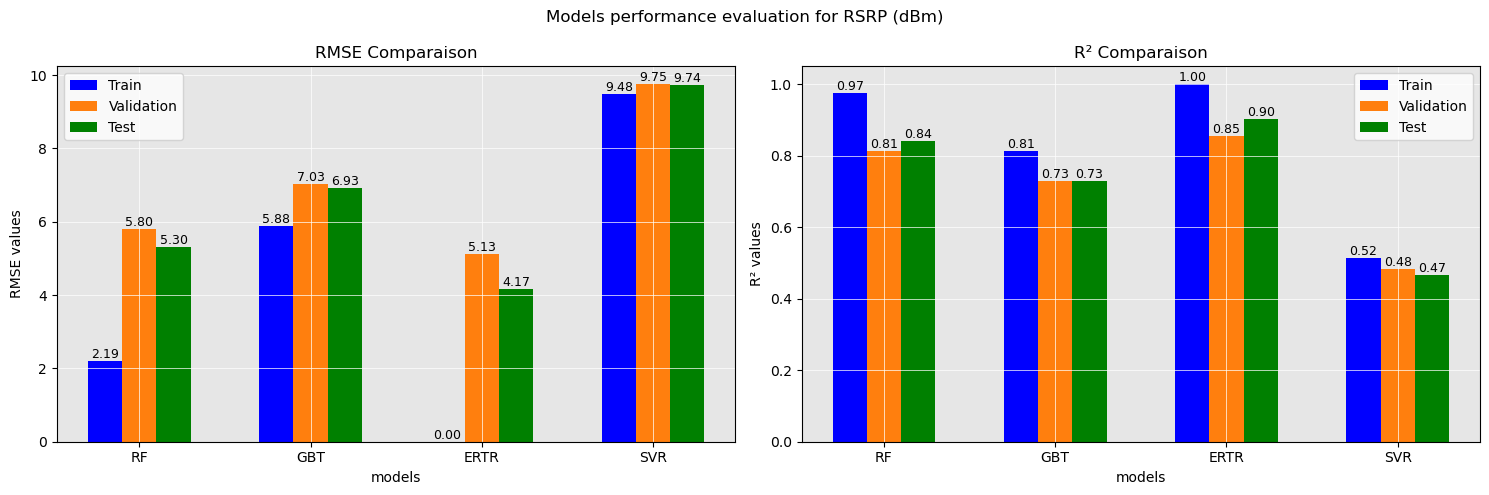

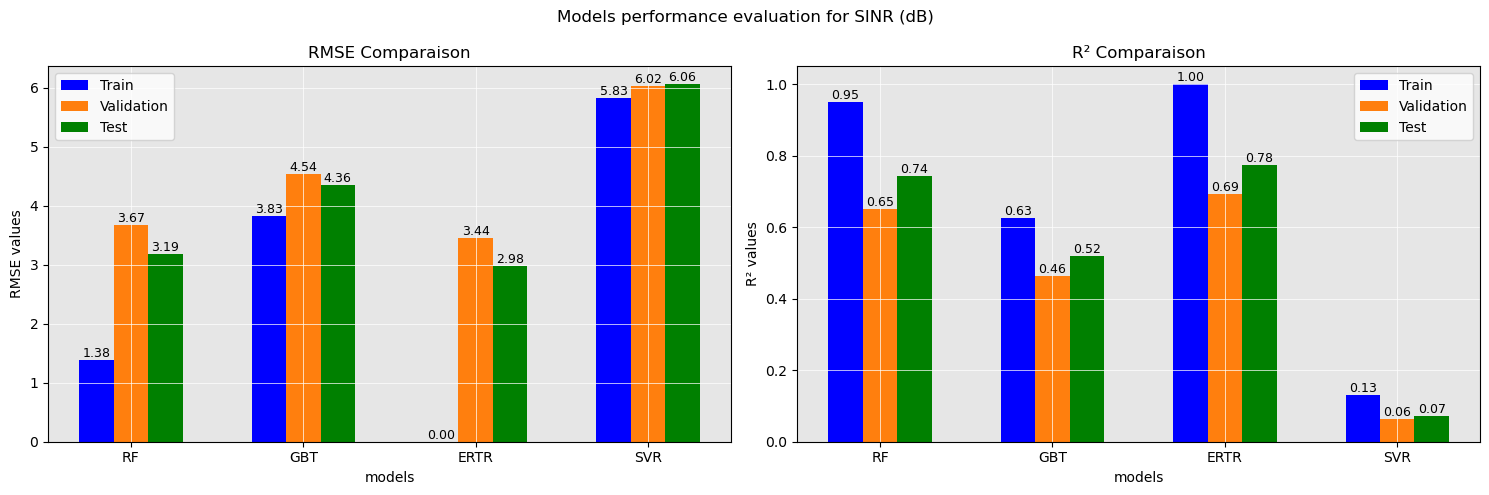

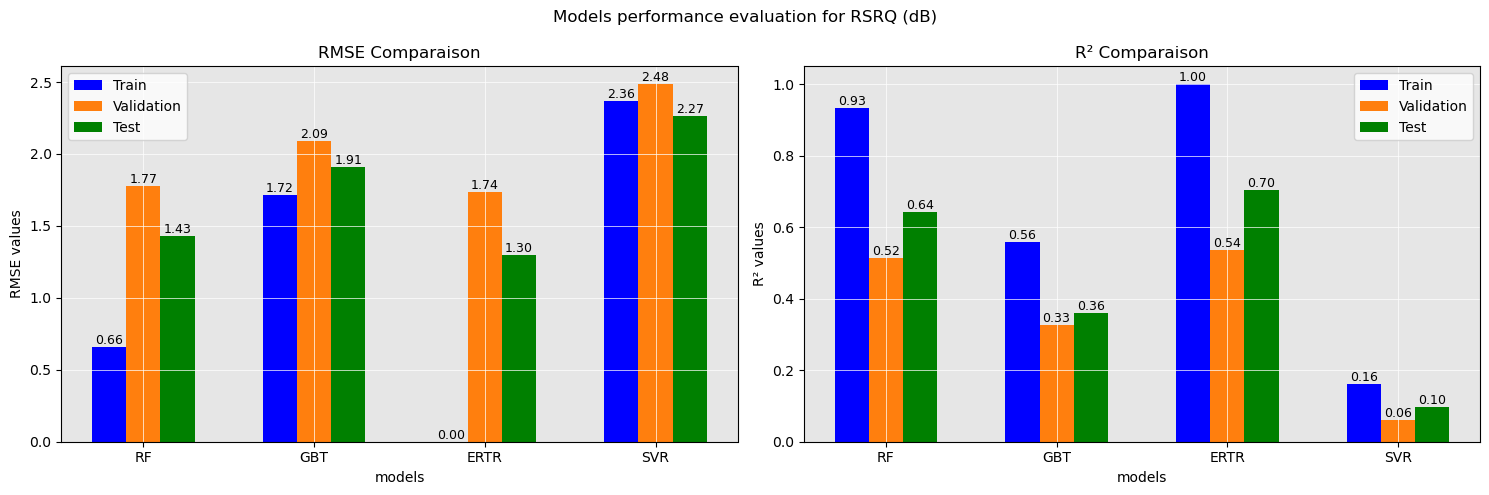

In [22]:
for target_name, target_results in results.items():
    #create a figure with 2 subplots
    fig, (plt1, plt2) = plt.subplots(1,2, figsize=(15,5))
    fig.suptitle(f'Models performance evaluation for {target_name}')

    x = np.arange(len(target_results.index))
    width = 0.2
    
    #RMSE plot1
    Tr_rmse_bar = plt1.bar(x- width , target_results['Train_RMSE'],width , color = 'blue', label ='Train')
    vl_rmse_bar = plt1.bar(x, target_results['Val_RMSE'],width ,  color = '#ff7f0e', label ='Validation')
    Te_rmse_bar = plt1.bar(x+ width, target_results['Test_RMSE'], width , color = 'green', label ='Test')

    plt1.set_title('RMSE Comparaison')
    plt1.set_xlabel('models')
    plt1.set_ylabel('RMSE values')
    plt1.set_xticks(x)
    plt1.set_xticklabels(models)
    plt1.set_facecolor((0.9,0.9,0.9))
    plt1.grid(True, linewidth = 0.5, color = 'white')
    plt1.legend()

    #R2 plot2
    Tr_r2_bar = plt2.bar(x- width , target_results['Train_R²'],width , color = 'blue', label = 'Train')
    vl_r2_bar = plt2.bar(x, target_results['Val_R²'],width , color = '#ff7f0e', label = 'Validation')
    Te_r2_bar = plt2.bar(x+ width , target_results['Test_R²'], width , color = 'green', label = 'Test')

    plt2.set_title('R² Comparaison')
    plt2.set_xlabel('models')
    plt2.set_ylabel('R² values')
    plt2.set_xticks(x)
    plt2.set_xticklabels(models)
    plt2.set_facecolor((0.9,0.9,0.9))
    plt2.grid(True, linewidth = 0.5, color = 'white')
    plt2.legend()

    add_value(plt1, [Tr_rmse_bar,vl_rmse_bar, Te_rmse_bar],9,2)
    add_value(plt2, [Tr_r2_bar,vl_r2_bar, Te_r2_bar],9,2)
    
    plt.tight_layout()
    plt.show()

### 2.3.1 'RSRP' metrics evaluation Analysis:
#### Random Forest 'RF': there is a strong fit on training data with R² = 0.97 and and error of 2.19. However there's a  drop of R² of 15% on validation data. which means there's a high possibility of overfitting as well as for testing data, this confirm why RMSE increased with 5.8 and 5.3 for validation and testing data sets, even though the model still solid indicating good generalisation.
#### Gradient Boosted Trees 'GBT': The model has weaker training performance with an RMSE of 5.88 fitting only 0.81 of training set, also the results are consistent( less overfitting) durting validation and test pahses with RMSE/ R² around 7/0.73 but still underperforms
#### Extremely Randomised Trees 'ERTR': shows perfect fit on training data with an RMSE/R²: 0/1 , this shows high variance (sign of significant overfiting), Despitethat, the model explain 90% of variation on test sets which the best of predicting the target RSRP values and a better accuracy of RMSE 4.17 on testing set with a validation result of an RMSE 5.13 (pretty stable)  but still need regularisation.
#### Support Vector Regression 'SVR': The model is poor in all phases (training , validation and test sets) with and average of RMSE of 9.5 with R²~ 0.5, this indicate an underfitting.
#### Despite overfitting the training set, 'ERTR' model generalises well and acheive the best accuracy and highest R². followed by 'RF' model with less overfitting but also slightly less accuracy on unseen data. 'GBT' model remain stable but mediocre results  this leads to underwhelme performance. 'SVR' model is fundamentally unsuitable for this target strrugling across all datasets with high error and low explanatory power (low R²)
### 2.3.2'SINR' metrics evaluation Analysis:
#### Regarding the Target 'SINR', all models have almost same metrics  evaluation trend as the previous target (RSRP) with a better accuracy, RMSE lowest than the previous target. However, even if the 'RF' and  'ERTR' shows a pretty well R² on testing set around  0.75, this still showing less ability to capture variance. folowed by 'GBT' algorithm failed to capture patterns with R² ~ 0.5 on tvalidation and testing set . 'SVR' consistently weak with an R² near to null shows a severe underfitting. 
### 2.3.3 'RSRQ' metrics evaluation Analysis:
#### 'ERTR' and 'RF' keep dominating by giving a very low error with an RMSE very low in all phases, but this shows an overfitting of the models, with a moderne generalisation with R² ~ 0.52 for on validation set and somehow an increase of 0.7 and 0.64 for the 'ERTR' and 'RF' models respectively. However, this is insufficient predictive power, this maybe because of  the values showed in validation and test set are too different and there are some outliers within validation sets.  Low variance explanation again for 'GBT' model even if the RMSE values are pretty close to the first models, 'SVr' keep performing the worst again. showing that's non-viable or at least need some tuning  the get better performance.


### Conclusion
#### In conclusion, even of the model 'ERTR' shows  the highest overfitting in training set, it's still outperforms other models to predict the value of all target variables (RSRP, RSRQ and SINR) in term of accuracy giving the lowest RMSE in  all phases and the highest explanation of the target variance (highest  R²). Consistently followed by 'RF' model which the most reliable with a small train-test gaps towards all targets. 'GBT' model underperformance, this might need some learning rate adjustment. Regarding 'SVR', it's a true fail, it imperatively need to do fine tuning on it such changing kernal from RBF to Linear.

### 3.Feature importance Analysis

#### Based on the previous model evaluation using RMSE and R² metrics, we observed that tree-based models (RF, GBT, and ERTR) demonstrated strong predictive performance across all target variables. However, the analysis revealed two key concerns:
#### Overfitting indicators: 
#### -'ERTR' model showed perfect training scores, suggesting potential overfitting to training data noise, and this could be because of noisy features.
#### -Also, 'RF' model exhibited notable gaps between training and validation R² scores, indicating room for improved generalisation. 
#### Model Interpretation Needs: while those metrics tell us how well models predict, they don't explain what leds these predictions.

#### Using feature importance analysis hekps us to determine which attributes truly influence predictions. By removing irrelevant features, it can improve model efficieny on reducing overfitting risks, lower computational costs and enhace generalisation capability. 
##### Note: note that we'll examine only tree based models since they are most promising results and also  SVR requires alternative methods which we'll be excluded.

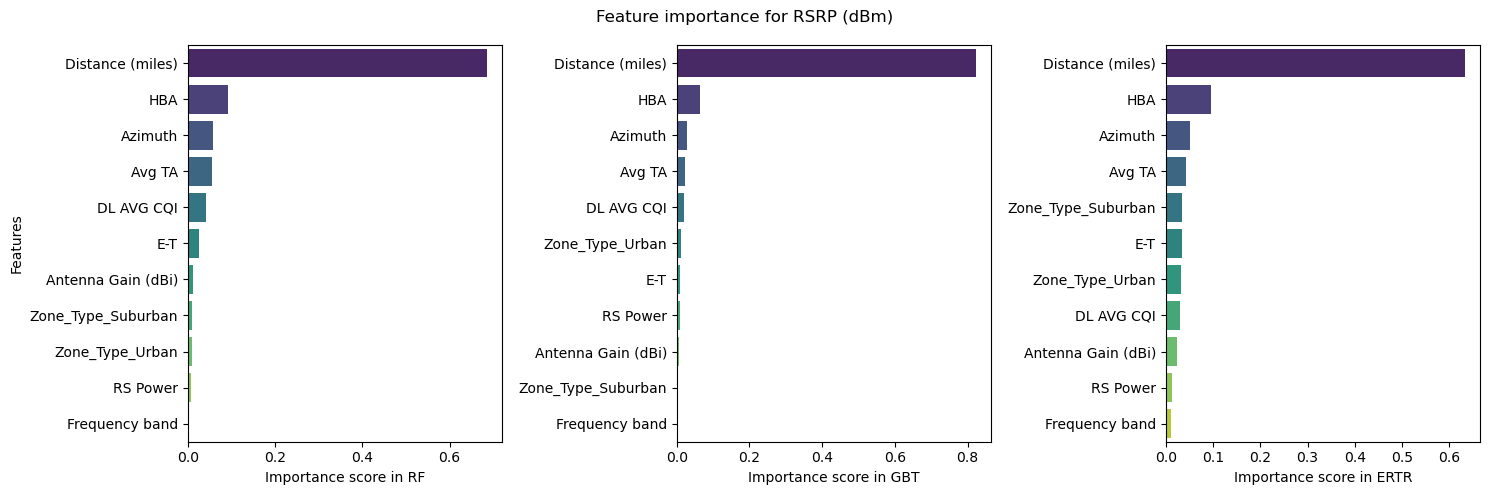


Feature Importance for RSRP (dBm):


,RF,GBT,ERTR
Feature,,,
Distance (miles),0.685605,0.823265,0.633017
HBA,0.092936,0.064948,0.095158
Azimuth,0.058228,0.028222,0.051481
Avg TA,0.055313,0.023005,0.042737
DL AVG CQI,0.042303,0.020019,0.030796
E-T,0.024870,0.009843,0.033581
Antenna Gain (dBi),0.011060,0.006303,0.024317
Zone_Type_Suburban,0.009700,0.003848,0.034780
Zone_Type_Urban,0.009036,0.010848,0.031935


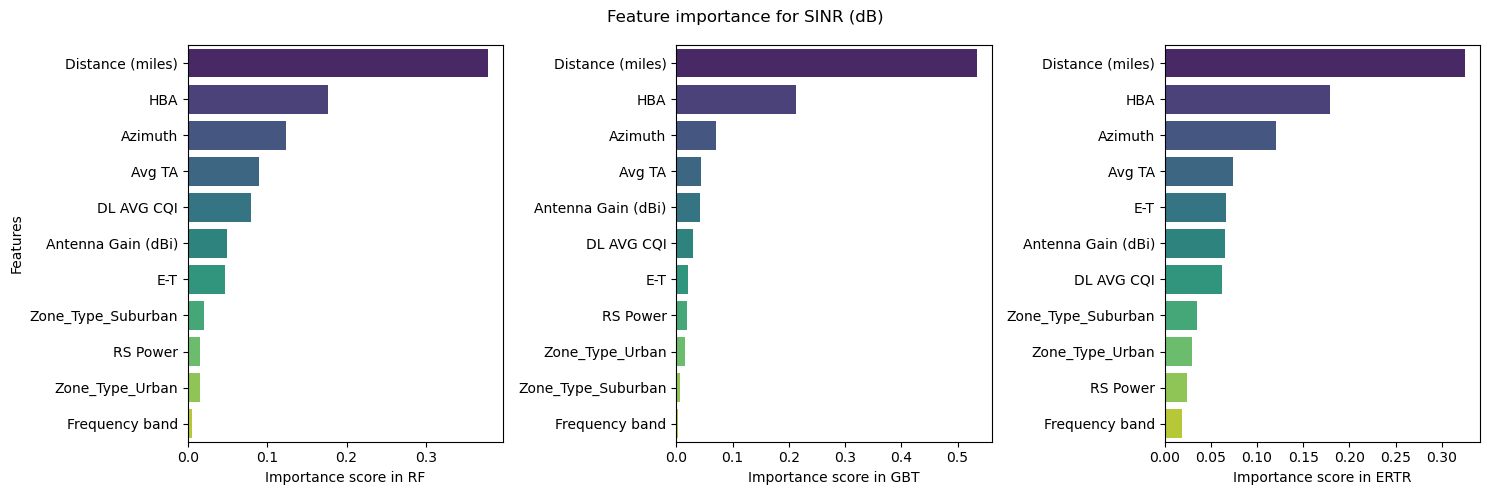


Feature Importance for SINR (dB):


,RF,GBT,ERTR
Feature,,,
Distance (miles),0.378198,0.533467,0.325239
HBA,0.176856,0.212569,0.179302
Azimuth,0.123123,0.070046,0.120876
Avg TA,0.089106,0.044840,0.074129
DL AVG CQI,0.080101,0.029602,0.062328
Antenna Gain (dBi),0.049083,0.042646,0.065460
E-T,0.046982,0.020493,0.066085
Zone_Type_Suburban,0.020904,0.007337,0.034425
RS Power,0.015121,0.018737,0.024439


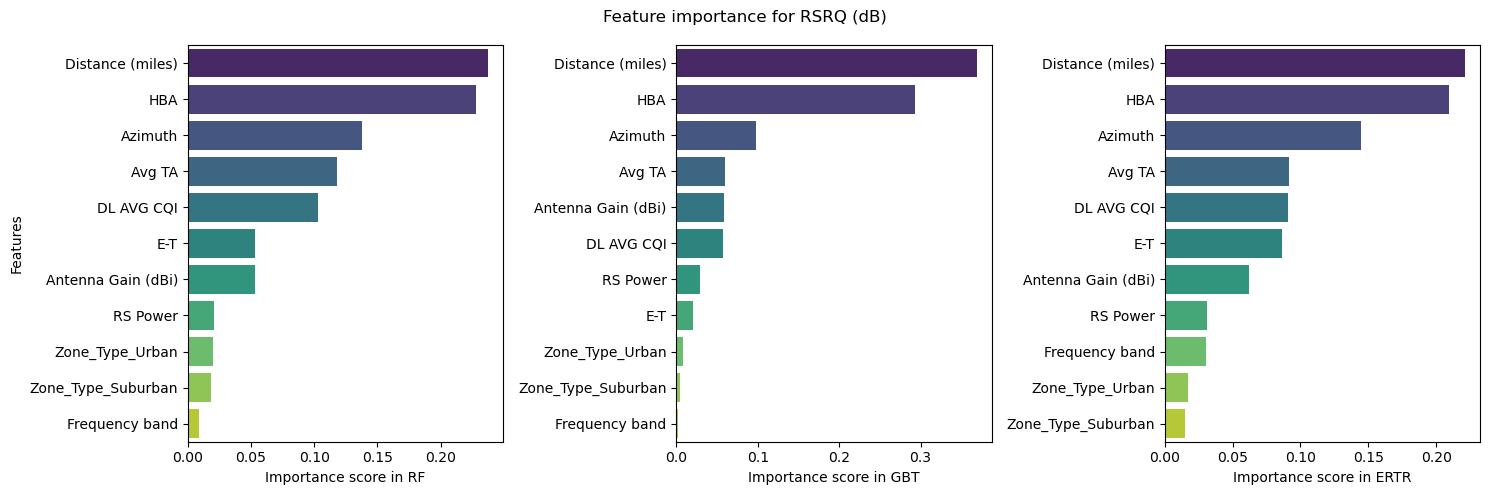


Feature Importance for RSRQ (dB):


,RF,GBT,ERTR
Feature,,,
Distance (miles),0.237599,0.368583,0.221242
HBA,0.227923,0.293110,0.209265
Azimuth,0.138147,0.097438,0.144879
Avg TA,0.118391,0.059597,0.091813
DL AVG CQI,0.103405,0.057861,0.090906
E-T,0.053557,0.020837,0.086265
Antenna Gain (dBi),0.053394,0.059026,0.062169
RS Power,0.020589,0.029217,0.030888
Zone_Type_Urban,0.019682,0.007713,0.017485


In [27]:
warnings.filterwarnings('ignore')


feature_importance_score = {}

for target_name in targets.keys():
    feature_importance_score[target_name]={}
    plt.figure(figsize =(15, 5))
    
    for i, (model_name, model)  in enumerate(trained_models[target_name].items()):
        if model_name == 'SVR':
            continue
        if hasattr(model, 'feature_importances_') :
            importance = pd.DataFrame({
                'Feature': X.columns,
                'Importance': model.feature_importances_
            }).sort_values(by = 'Importance', ascending = False)
    
            feature_importance_score[target_name][model_name] = importance
            
            plt.subplot(1, len(models)-1, i+1)
            sns.barplot(x= 'Importance', 
                    y= 'Feature',
                    data = importance,
                    palette = 'viridis'
                   )
        
            plt.xlabel(f'Importance score in {model_name}')
            plt.ylabel('Features'if i ==0 else'')
            
    plt.suptitle(f'Feature importance for {target_name}')
    plt.tight_layout()
    plt.savefig(f'Feature_Importance_{target_name}.png', dpi =300)
    plt.show()
    
    if feature_importance_score.get(target_name):
        print(f"\nFeature Importance for {target_name}:")
        dfs = []
        for model_name, df in feature_importance_score[target_name].items():
            dfs.append(df.set_index('Feature').rename(columns={'Importance': model_name}))
                
        display(pd.concat(dfs, axis =1))


#### Based on the feature importance results, we observe a clear patterns that inform which features to retain for optimal model performance. 'Distance' is is by far the most important predictor across all targts and models, with particuallry in RSRP prediction  (0.68-0.82). This alligns with wireless signal propagation physics, where distance impacts signal strength. Followed by HBA, and Azimuth. Antenna gain, CQI, and AVG TA have less importance with an average of 5 to 10% of the total importance for each attribute. for the rest features it has demonstrate marginal importance and can likely be removed to reduce overfitting and computational cost such as Frequency band, Zone_typrs and the power.
#### In order to simplify the modeks, we'll keep only top 3 features for each target variable in each model, this might lose a small amount of predictive  small amount of predictive accuracy, if it doesnt drop noticeably, we will keep it otherwise we will add additional features like Avg TA, CQI or E-T. This gain better generalisation (higher R2)

### 4.1. Evaluation Metrics and Dataset Splitting with only 3 top features

#### Next, we will repeat the same evaluation process used with the default models including the 10-fold cross-validation and train-test split, but this time using only the top three most important features. The goal is to compare the results with the initial full-feature models and assess the impact of feature reduction.

In [31]:
X_FI = Data.drop(columns = [ 'E-T', 'Antenna Gain (dBi)', 'Frequency band','Avg TA',
       'RS Power', 'DL AVG CQI', 'Zone_Type_Suburban', 'Zone_Type_Urban', 'RSRP (dBm)', 'SINR (dB)', 'RSRQ (dB)'])

### 4.2 Computational cost using top 3 features as predictors

In [33]:
trained_models, cv_results, FI_results = models_evaluation(X_FI, targets, cv, models)


Time Execution for each model on RSRP (dBm) target
Execution time: 2.408 seconds for "RF" 
Execution time: 0.948 seconds for "GBT" 
Execution time: 1.681 seconds for "ERTR" 
Execution time: 1.493 seconds for "SVR" 

Time Execution for each model on SINR (dB) target
Execution time: 2.617 seconds for "RF" 
Execution time: 0.965 seconds for "GBT" 
Execution time: 1.684 seconds for "ERTR" 
Execution time: 1.448 seconds for "SVR" 

Time Execution for each model on RSRQ (dB) target
Execution time: 2.498 seconds for "RF" 
Execution time: 0.958 seconds for "GBT" 
Execution time: 1.808 seconds for "ERTR" 
Execution time: 1.516 seconds for "SVR" 


#### Across all target variables, the Gradient Boosting Tree 'GBT' had the fastest execution time, averaging around 0.9 seconds. Followed by 'SVR' and 'ERTR' with an average of ~1.3 and ~1.55 seconds for each model in each target variables respectively. the Random Forest 'RF' model was the slowest, taking approximately 2.3 seconds per target.
#### After reducing the input predictors, all models denibstrated a significant improvement in computational cost across all target variables. GBT remained the most efficient model in terms of execution time, overtaking SVR, which had previously been the fastest when using all features

### 4.3 Metrics Evaluation with top 3 features

In [36]:
display_metrics_results(FI_results, 'with top 3 features importance')


          **RSRP (dBm) metrics evaluation with top 3 features importance**

     Train_RMSE  Train_R²  Val_RMSE    Val_R² Test_RMSE   Test_R²
RF     2.167386  0.974628  4.538871  0.884548   3.77744  0.919837
GBT    6.346811  0.782532  6.932959  0.736409  6.778725  0.741847
ERTR   1.386249  0.989597  3.978166  0.910376   3.16692  0.943655
SVR    9.526463  0.510179  9.605018  0.495937  9.892363  0.450231

          **SINR (dB) metrics evaluation with top 3 features importance**

     Train_RMSE  Train_R²  Val_RMSE    Val_R² Test_RMSE   Test_R²
RF     1.291759  0.957271   2.84453  0.788923  2.446602  0.848544
GBT    3.955824  0.599472  4.377718  0.503019  4.159034  0.562331
ERTR   0.756753  0.985267  2.461513  0.841756  2.328578  0.862804
SVR    5.973499  0.086779  6.048316  0.054986   6.12253  0.051533

          **RSRQ (dB) metrics evaluation with top 3 features importance**

     Train_RMSE  Train_R²  Val_RMSE    Val_R² Test_RMSE   Test_R²
RF     0.591147  0.947597  1.391763  0.698214

In [37]:
def Show_bar_graphs (drop, first_result, second_result): 
    combined_dict = {}
    for key in first_result.keys():
        before_tuning_metrics = first_result[key]
        after_tuning_metrics = second_result[key]
    
        # Store both as a tuple or another dict
        combined_dict[key] = {
            'Before_Tuning': before_tuning_metrics,
            'After_Tuning': after_tuning_metrics
        }
    for target_name, target_results in combined_dict.items():
        before_tuning = target_results['Before_Tuning']
        after_tuning = target_results['After_Tuning']
        tuned = 'tuned'
       # if drop == 0:
            #before_tuning = before_tuning.drop('SVR')
            #after_tuning = after_tuning.drop('SVR')
            #tuned = 'top_3_features'
        #else:
            #tuned = 'tuned'
        
        #create a figure with 2 subplots
        fig, (plt1, plt2) = plt.subplots(1,2, figsize=(15,5))
        fig.suptitle(f'Models performance evaluation for {target_name}\n')
    
        models = before_tuning.index.tolist()
        x = np.arange(len(models))
        width = 0.1
    
        
        #RMSE plot1
        Tr_rmse_bar = plt1.bar(x- 3*width , before_tuning['Train_RMSE'],width , color = 'blue', label ='Train')
        vl_rmse_bar = plt1.bar(x- 2*width, before_tuning['Val_RMSE'],width ,  color = '#ff7f0e', label ='Validation')
        Te_rmse_bar = plt1.bar(x -width, before_tuning['Test_RMSE'], width , color = 'green', label ='Test')
    
        Tr_rmse_tuned_bar = plt1.bar(x+ width , after_tuning['Train_RMSE'],width , color = 'lightblue', label =f'Train_{tuned}')
        vl_rmse_tuned_bar = plt1.bar(x+ 2*width, after_tuning['Val_RMSE'],width ,  color = 'navajowhite', label =f'Validation_{tuned}')
        Te_rmse_tuned_bar = plt1.bar(x+ 3*width, after_tuning['Test_RMSE'], width , color = 'lightgreen', label =f'Test_{tuned}')
    
        plt1.set_title('RMSE Comparaison')
        plt1.set_xlabel('models')
        plt1.set_ylabel('RMSE values')
        plt1.set_xticks(x)
        plt1.set_xticklabels(models)
        plt1.set_facecolor((0.9,0.9,0.9))
        plt1.grid(True, linewidth = 0.5, color = 'white')
        #plt1.legend()
    
    
           #R2 plot2
        Tr_r2_bar = plt2.bar(x- 3*width , before_tuning['Train_R²'],width , color = 'blue', label = 'Train')
        vl_r2_bar = plt2.bar(x- 2*width, before_tuning['Val_R²'],width , color = '#ff7f0e', label = 'Validation')
        Te_r2_bar = plt2.bar(x- width , before_tuning['Test_R²'], width , color = 'green', label = 'Test')
    
        Tr_r2_tuned_bar = plt2.bar(x+ width , after_tuning['Train_R²'],width , color = 'lightblue', label = f'Train_{tuned}')
        vl_r2_tuned_bar = plt2.bar(x+ 2*width, after_tuning['Val_R²'],width , color = 'navajowhite', label = f'Validation_{tuned}')
        Te_r2_tuned_bar = plt2.bar(x+ 3*width , after_tuning['Test_R²'], width , color = 'lightgreen', label = f'Test_{tuned}')
    
        plt2.set_title('R² Comparaison')
        plt2.set_xlabel('models')
        plt2.set_ylabel('R² values')
        plt2.set_xticks(x)
        plt2.set_xticklabels(models)
        plt2.set_facecolor((0.9,0.9,0.9))
        plt2.grid(True, linewidth = 0.5, color = 'white')
        #plt2.legend()
    
    
        
        add_value(plt1, [Tr_rmse_bar,vl_rmse_bar, Te_rmse_bar,Tr_rmse_tuned_bar,vl_rmse_tuned_bar,Te_rmse_tuned_bar],6,2)
        add_value(plt2, [Tr_r2_bar,vl_r2_bar, Te_r2_bar,Tr_r2_tuned_bar,vl_r2_tuned_bar,Te_r2_tuned_bar],6,2)
    
        fig.subplots_adjust(top = 0.7)
        handles, labels = plt2.get_legend_handles_labels()
        fig.legend(handles, labels, loc = 'lower center',ncol = 6, bbox_to_anchor=(0.5, -0.07))
        
        plt.tight_layout(rect=  [0,0,1,1])
        plt.savefig(f'Model_evaluation_3TF_{target_name}.png', dpi =300)
        plt.show()

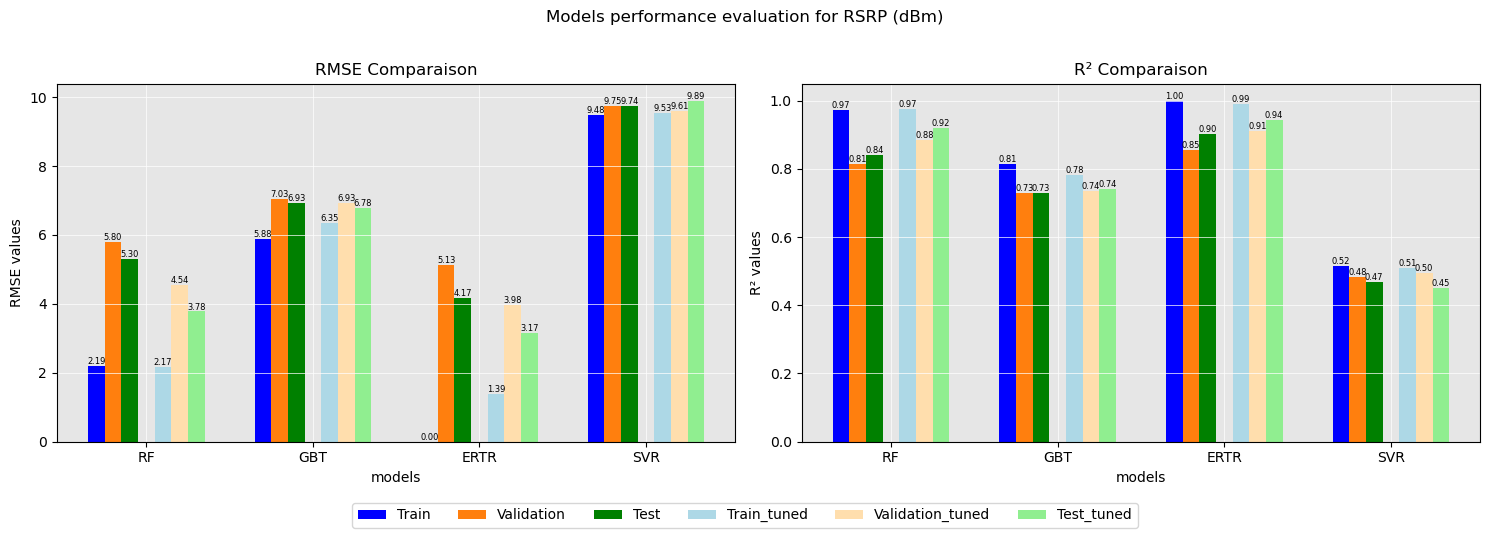

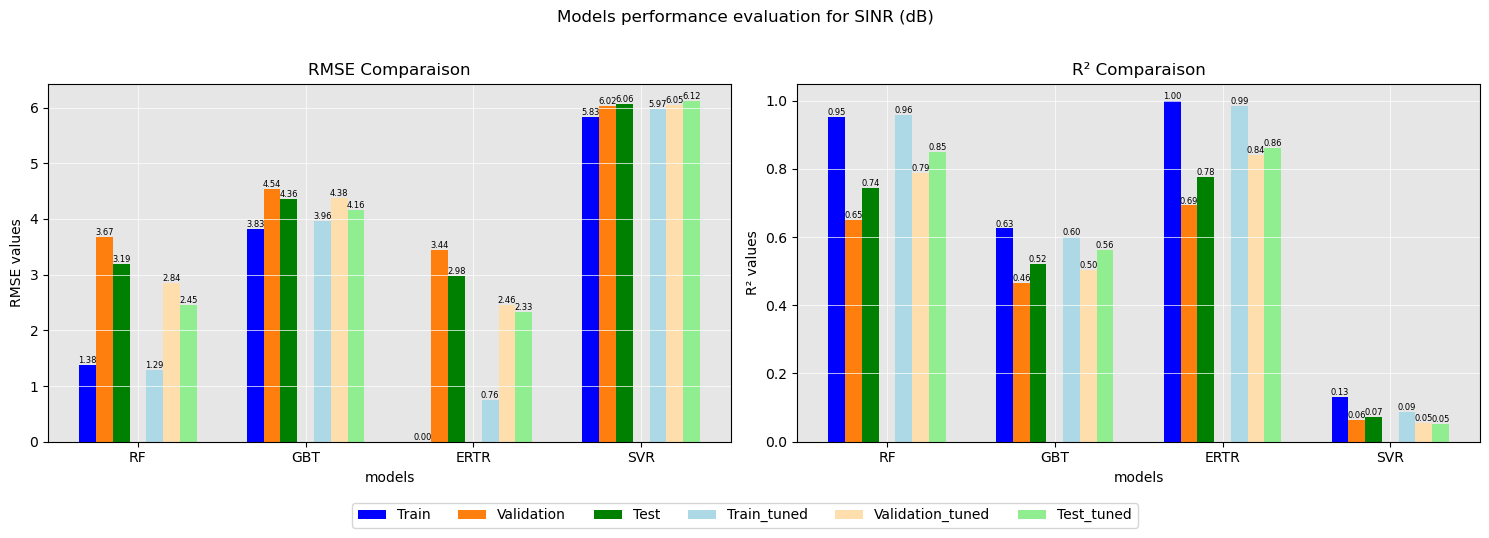

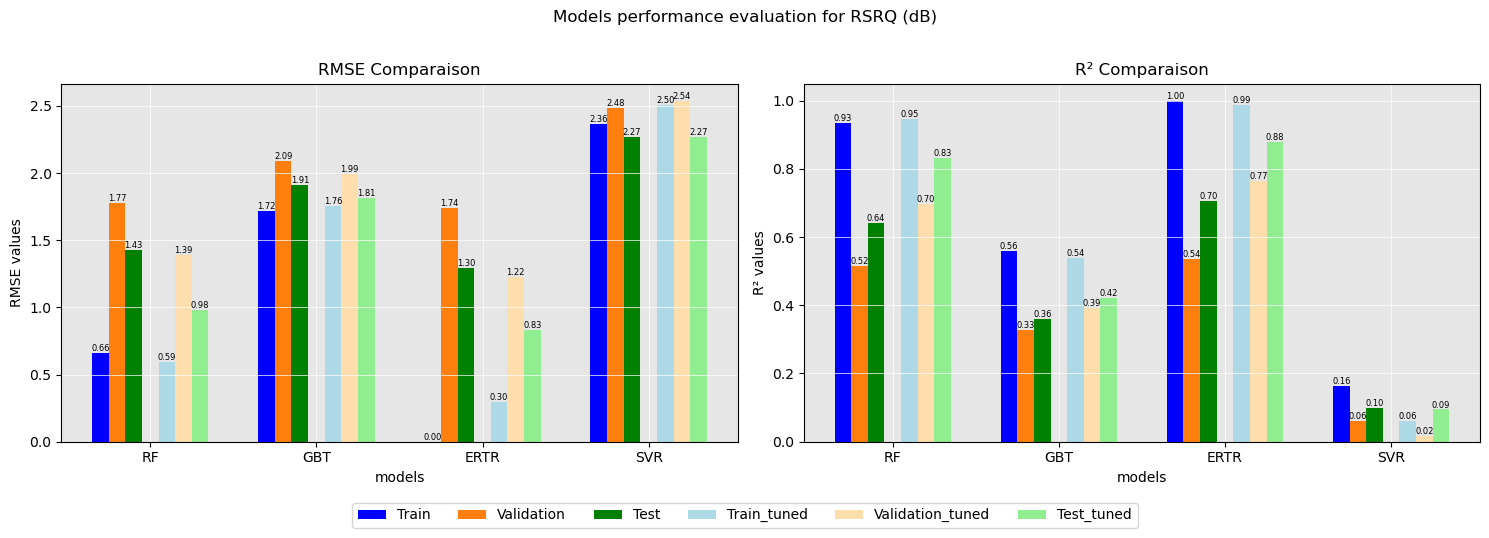

In [38]:
Show_bar_graphs(0,results, FI_results)

#### Reducing the features improve model performance across all target variables. particullary for ERTR andf RF, with lower RMSE , higher R2, and better generalisation on unseen data (better R2 on validation, test sets).
#### Feature reduction helped to reducce overfitting and eliminate redundancy. a smart and effective optimisation step.

### 5.Metrics Evaluation with top 3 features with hyperparameters tuning

In [41]:
tree_based_tuning = {
    'n_estimators': [20,50,80,110,140,170,100],
    'max_depth':[None, 5, 10 , 15, 20, 30],
    'min_samples_split': [2, 4 ,6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],# leaf sizes
    'max_features': ['sqrt', 'log2']
}

SVR_tuning = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5, 1],
    #'kernel':['Linear', 'rbf', 'poly'],
    'svr__kernel':['Linear', 'rbf'],
    'svr__gamma': ['scale','auto'],
    #'degree': [1, 2,3 , 4]# this is only for poly SVR
}

In [42]:
tuning_grid = {
    'RF': tree_based_tuning,
    'GBT': tree_based_tuning,
    'ERTR': tree_based_tuning,
    'SVR': SVR_tuning
} 

In [43]:
tuning_results = {}
best_models = defaultdict(dict) # automatically create sub-dictionnary

In [44]:
for target_name, y in targets.items():
    print(f'\nModel Evaluation for {target_name}')
    print( 30* '=')
    #Keeping same split_test
    X_train, X_test, y_train, y_test = train_test_split(
        X_FI, y, test_size = 0.2, shuffle = True, random_state = 19)

    tuning_results[target_name]={}
    
    for model_name, model in models.items():
        start_time = time.time()
        model_tuned = RandomizedSearchCV(
            estimator = model,#  model
            param_distributions = tuning_grid[model_name], #tunning parameters
            n_iter = 60, #number of combination
            #n_iter = 20, #number of combination
            cv =cv, #kfold cross validation
            scoring = {'RMSE':'neg_root_mean_squared_error',
                       'R2': 'r2'},
            refit = 'RMSE', # final model will chose based on best RMSE
            n_jobs = -1, # this for parallel processing, to make it faster and test different combination simultaniously
            random_state = 19,
            #verbose = 0 #show completion time
        )

        
        model_tuned.fit(X_train, y_train)
        end_time = time.time()

        # Get time needed to fit each model in each targetfeature
        execution_time = end_time - start_time
        print(f'\nExecution time: {execution_time:.6f} seconds for "{model_name}" model\n')

        print(f'Best combination parameter for {model_name} model:')
        for parameter, value in model_tuned.best_params_.items():
            print(f'   {parameter}:  {value}')
        
        # Store best models for each target variable
        best_model = model_tuned.best_estimator_
        best_models[target_name][model_name] = best_model
        
        y_test_pred = best_model.predict(X_test)
        y_train_pred = best_model.predict(X_train)

        mean_val_r2 = model_tuned.cv_results_['mean_test_R2'][model_tuned.best_index_]
        
        #Store results as previous
        tuning_results[target_name][model_name] = {
            'Best_combination': model_tuned.best_params_,
            'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'Train_R²': r2_score(y_train, y_train_pred),
            'Val_RMSE': -model_tuned.best_score_,
            'Val_R²': mean_val_r2,
            'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'Test_R²': r2_score(y_test, y_test_pred),
                        
        }
        


Model Evaluation for RSRP (dBm)

Execution time: 14.397627 seconds for "RF" model

Best combination parameter for RF model:
   n_estimators:  170
   min_samples_split:  2
   min_samples_leaf:  1
   max_features:  sqrt
   max_depth:  20

Execution time: 7.185261 seconds for "GBT" model

Best combination parameter for GBT model:
   n_estimators:  100
   min_samples_split:  8
   min_samples_leaf:  1
   max_features:  log2
   max_depth:  None

Execution time: 6.451668 seconds for "ERTR" model

Best combination parameter for ERTR model:
   n_estimators:  170
   min_samples_split:  2
   min_samples_leaf:  1
   max_features:  sqrt
   max_depth:  20

Execution time: 3.217863 seconds for "SVR" model

Best combination parameter for SVR model:
   svr__kernel:  rbf
   svr__gamma:  auto
   svr__epsilon:  1
   svr__C:  100

Model Evaluation for SINR (dB)

Execution time: 9.376248 seconds for "RF" model

Best combination parameter for RF model:
   n_estimators:  170
   min_samples_split:  2
   min_s

#### Above shows the results of best combination for each model in each target variable

In [46]:
#Getting a display new dataframe tuning results without 'Best_combination' Values

tuning_results_dict = {}

for target_name, models in tuning_results.items():
    print(f'\n{target_name} metrics evaluation with models tuned\n')
    model_metrics = {}
    
    for model_name, metrics in models.items():
        model_metrics[model_name] = {
                'Train_RMSE': metrics ['Train_RMSE'],
                'Train_R²': metrics ['Train_R²'],
                'Val_RMSE': metrics ['Val_RMSE'],
                'Val_R²': metrics ['Val_R²'],
                'Test_RMSE': metrics ['Test_RMSE'],
                'Test_R²': metrics ['Test_R²']
            }
    tuning_results_dict[target_name] = pd.DataFrame.from_dict(model_metrics, orient = 'index')
    print(tuning_results_dict[target_name])


RSRP (dBm) metrics evaluation with models tuned

      Train_RMSE  Train_R²  Val_RMSE    Val_R²  Test_RMSE   Test_R²
RF      2.137508  0.975343  4.872242  0.868678   4.101576  0.905489
GBT     1.404053  0.989361  4.261805  0.898286   3.642123  0.925477
ERTR    1.489287  0.988030  4.298240  0.897176   3.409229  0.934703
SVR     8.958351  0.566906  9.363119  0.521898   9.489041  0.494146

SINR (dB) metrics evaluation with models tuned

      Train_RMSE  Train_R²  Val_RMSE    Val_R²  Test_RMSE   Test_R²
RF      1.264022  0.959115  3.010322  0.763034   2.640028  0.823649
GBT     0.767845  0.984913  2.686650  0.812434   2.265626  0.870122
ERTR    0.817963  0.982879  2.572674  0.826744   2.342181  0.861196
SVR     5.485771  0.229924  5.821767  0.117230   5.921630  0.112756

RSRQ (dB) metrics evaluation with models tuned

      Train_RMSE  Train_R²  Val_RMSE    Val_R²  Test_RMSE   Test_R²
RF      0.567211  0.951811  1.409783  0.693084   1.013588  0.819631
GBT     0.302046  0.986335  1.239208

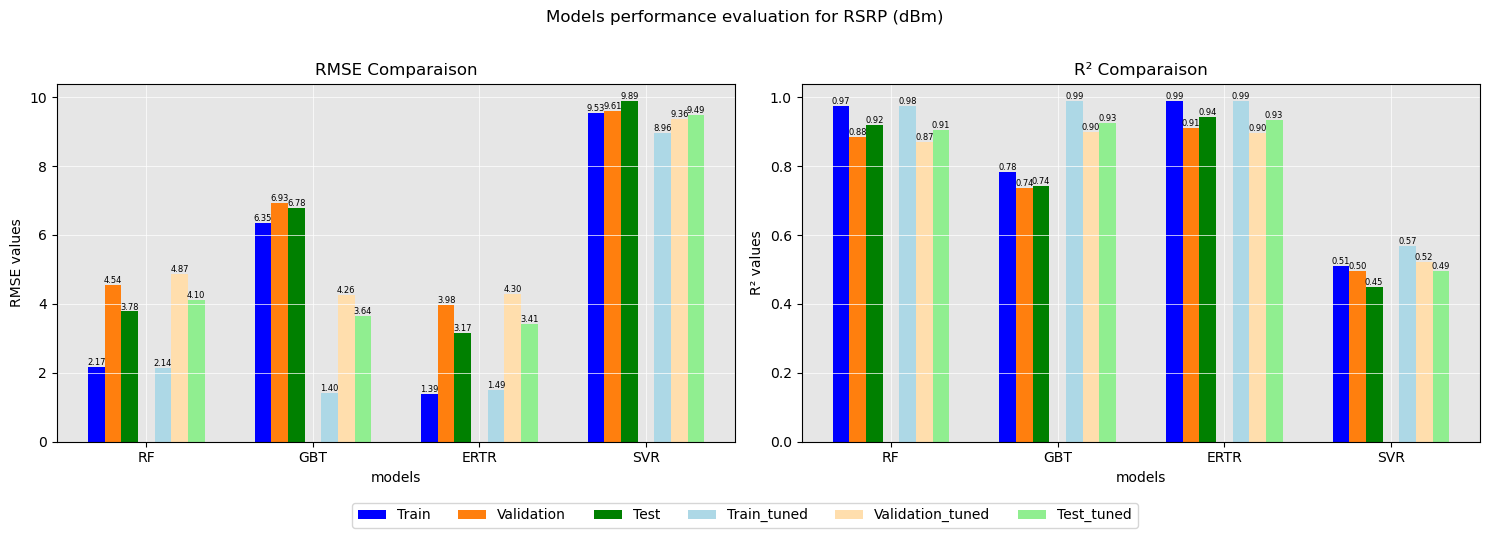

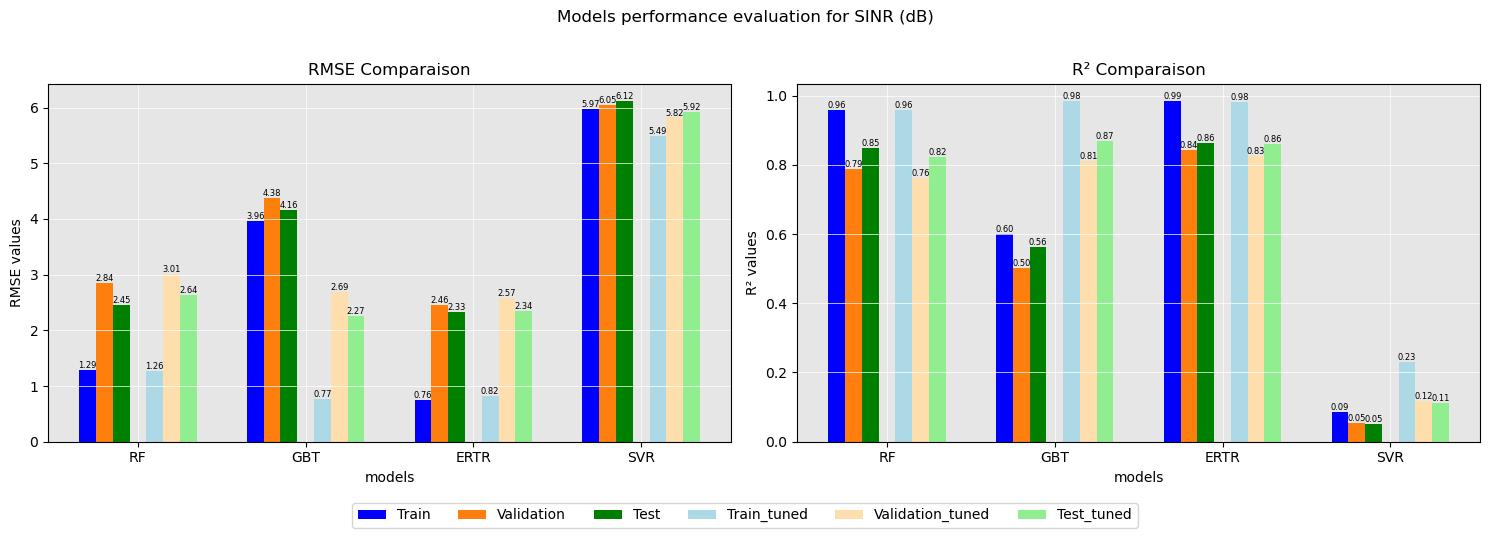

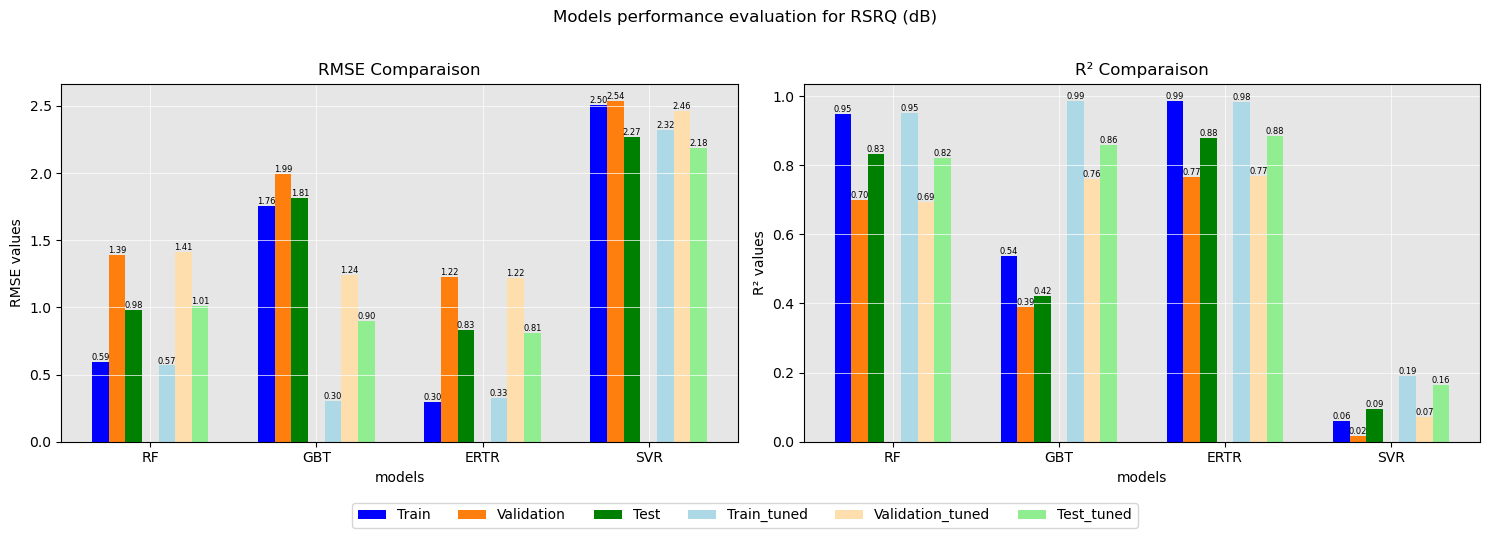

In [47]:
Show_bar_graphs(1, FI_results, tuning_results_dict)

In [48]:
### ERTR is the best in term of time execution, GBT  and ERTR are so close in term of performance 

In [49]:
#Saving ERTR model for Example this will be choosed after commenting
for target_name in best_models:
    ertr_model = best_models[target_name]['ERTR']
    filename = f"Best_model_for_{target_name.replace(' (dBm)','').replace(' (dB)','')}.joblib"
    dump(ertr_model, filename)
    print(f'Saved model for {target_name}')

Saved model for RSRP (dBm)
Saved model for SINR (dB)
Saved model for RSRQ (dB)
